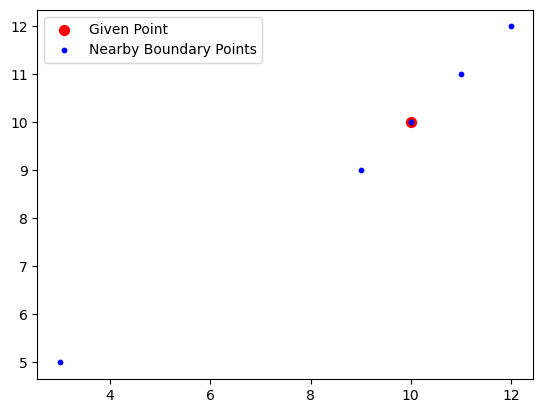

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_nearby_points(boundary_points, given_point, distance_threshold=10):
    """
    Plot boundary points that are within a specified distance from a given point.

    Args:
    - boundary_points: 2D array of boundary points
    - given_point: A point [x, y]
    - distance_threshold: Distance within which to select and plot boundary points
    """

    boundary_points_array = np.array(boundary_points)
    given_point_array = np.array(given_point)

    # Calculate Euclidean distance between the given point and each boundary point
    distances = np.linalg.norm(boundary_points_array - given_point_array, axis=1)

    # Select boundary points within the distance threshold
    nearby_points = boundary_points_array[distances < distance_threshold]

    # Plot the given point
    plt.scatter(given_point[0], given_point[1], color='red', s=50, label='Given Point')

    # Plot the nearby boundary points
    plt.scatter(nearby_points[:, 0], nearby_points[:, 1], color='blue', s=10, label='Nearby Boundary Points')

    plt.legend()
    plt.show()

# Example data
boundary_points = [[1, 1], [2, 3], [3, 5], [9, 9], [10, 10], [11, 11], [12, 12]]
given_point = [10, 10]

plot_nearby_points(boundary_points, given_point, distance_threshold=10)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Cosine Similarity between cropped edges of images
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from scipy.spatial.distance import cosine
from PIL import Image
from scipy import spatial
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d


np.set_printoptions(precision=3)

(<matplotlib.image.AxesImage at 0x7efe5b0a5df0>, (224, 224, 3))

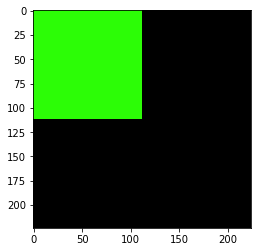

In [33]:
rectangle_img = np.zeros((1080, 1920))
rectangle_img[450:650, 800:1100] = 1
corners = [(450, 800), (450, 1100), (650, 800), (650, 1100)]

cols = np.random.rand(3)
for corner in corners:
    img_patch = rectangle_img[corner[0]-112:corner[0]+112, corner[1]-112:corner[1]+112]
    img_patch = np.dstack((img_patch, img_patch, img_patch))*cols
plt.imshow(img_patch), img_patch.shape

In [26]:
# Load the pretrained ResNet model
model = resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

# Load an image of a rectangle
image = rectangle_img

# Define the corners' coordinates
corners = [(450, 800), (450, 1100), (650, 800), (650, 1100)]

# Preprocess the images and pass through the ResNet model
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

corner_features = []
with torch.no_grad():
    for corner in corners:
        # Crop the corner from the image
        corner_img = image[corner[0]-112:corner[0]+112, corner[1]-112:corner[1]+112]
        corner_img = np.dstack((corner_img*0.8, corner_img*1, corner_img*0.1))
        corner_img = Image.fromarray(np.uint8(corner_img*255))
        corner_img = transform(corner_img).unsqueeze(0)
        
        # Forward pass through ResNet
        corner_feature = model(corner_img)
        corner_features.append(corner_feature.squeeze())

# Compute cosine similarity scores
similarity_matrix = torch.zeros((4, 4))
for i in range(4):
    for j in range(4):
        similarity_matrix[i, j] = 1 - cosine(corner_features[i], corner_features[j])

print(similarity_matrix)

tensor([[1.0000, 0.9576, 0.9331, 0.9239],
        [0.9576, 1.0000, 0.9223, 0.9386],
        [0.9331, 0.9223, 1.0000, 0.9707],
        [0.9239, 0.9386, 0.9707, 1.0000]])


In [ ]:
def pixel_to_xy(points, origin_pixel, scale_factors):
    """
    Convert an array of 2D points from pixel space to 2D XY-space.

    Args:
    points (list of tuples): List of (x_pixel, y_pixel) pixel coordinates.
    origin_pixel (tuple): (x_origin, y_origin) pixel coordinates of the origin.
    scale_factors (tuple): (x_scale, y_scale) scale factors for X and Y axes.

    Returns:
    list of tuples: List of (x_xy, y_xy) XY-space coordinates.
    """
    xy_points = []
    for x_pixel, y_pixel in points:
        x_xy = (x_pixel - origin_pixel[0]) * scale_factors[0]
        y_xy = (origin_pixel[1] - y_pixel) * scale_factors[1]
        xy_points.append((x_xy, y_xy))
    return xy_points

    # Define pixel coordinates of points
pixel_points = [(100, 200), (150, 250), (200, 300)]

# Define origin and scale factors
origin_pixel = (50, 50)  # Example origin in pixel space
scale_factors = (0.1, 0.1)  # Example scale factors

# Convert to XY-space coordinates
xy_points = pixel_to_xy(pixel_points, origin_pixel, scale_factors)

# Print the resulting XY-space coordinates
print(xy_points)

In [ ]:
def get_nearest_robot_and_crop(self, env_idx):
        # plt.figure(figsize=(6.6667,11.85))
        img = self.current_scene_frame['color'].data.astype(np.uint8)
        # plt.imshow(img)
        # plt.show()
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, self.lower_green_filter, self.upper_green_filter)
        seg_map = cv2.bitwise_and(img, img, mask = mask)
        seg_map = cv2.cvtColor(seg_map, cv2.COLOR_BGR2GRAY)

        boundary = cv2.Canny(seg_map,100,200)
        boundary_pts = np.array(np.where(boundary==255)).T
        # 0, 1920 are origin pixels in img space
        boundary_pts[:,0] = (boundary_pts[:,0] - 0)/1080*(self.plane_size[1][0]-self.plane_size[0][0])+self.plane_size[0][0]
        boundary_pts[:,1] = (1920 - boundary_pts[:,1])/1920*(self.plane_size[1][1]-self.plane_size[0][1])+self.plane_size[0][1]
        
        # plt.scatter(boundary_pts[:,0], boundary_pts[:,1], c='b')
        # plt.scatter(self.nn_helper.kdtree_positions[:,0], self.nn_helper.kdtree_positions[:,1], c='r')
        # plt.show()
        com = np.mean(boundary_pts, axis=0)

        if len(boundary_pts) > 200:
            self.bd_pts[env_idx] = boundary_pts[np.random.choice(range(len(boundary_pts)), size=200, replace=False)]
        else:
            self.bd_pts[env_idx] = boundary_pts
        idxs, neg_idxs = self.nn_helper.get_nn_robots(self.bd_pts[env_idx])
        idxs = np.array(list(idxs))
        min_idx = tuple(idxs[np.lexsort((idxs[:, 0], idxs[:, 1]))][0])
        
        """ Single Robot Experiment. Change this to include entire neighborhood """
        self.active_idxs[env_idx] = {min_idx: np.array((0,0))} # Store the action vector as value here later :)
        # [self.active_idxs[idx]=np.array((0,0)) for idx in idxs]

        idxs = np.array(list(idxs))
        neighbors = self.nn_helper.robot_positions[idxs[:,0], idxs[:,1]]

        finger_pos = self.nn_helper.robot_positions[min_idx].copy()
        finger_pos[0] = (finger_pos[0] - self.plane_size[0][0])/(self.plane_size[1][0]-self.plane_size[0][0])*1080 - 0
        finger_pos[1] = 1920 - (finger_pos[1] - self.plane_size[0][1])/(self.plane_size[1][1]-self.plane_size[0][1])*1920
        finger_pos = finger_pos.astype(np.int32)

        # plt.imshow(seg_map)
        # for i in range(8):
        #     for j in range(8):
        #         finger_pos = self.nn_helper.robot_positions[i,j].copy()
        #         finger_pos[0] = (finger_pos[0] - self.plane_size[0][0])/(self.plane_size[1][0]-self.plane_size[0][0])*1080 - 0
        #         finger_pos[1] = 1920 - (finger_pos[1] - self.plane_size[0][1])/(self.plane_size[1][1]-self.plane_size[0][1])*1920
        #         finger_pos = finger_pos.astype(np.int32)

        #         plt.scatter(finger_pos[1], finger_pos[0], c='r')        
        # plt.show()

        crop = seg_map[finger_pos[0]-224:finger_pos[0]+224, finger_pos[1]-224:finger_pos[1]+224]
        crop = cv2.resize(crop, (224,224), interpolation=cv2.INTER_AREA)
        # plt.imshow(crop)
        # plt.show()
        cols = np.random.rand(3)
        crop = np.dstack((crop, crop, crop))*cols
        crop = Image.fromarray(np.uint8(crop*255))
        crop = self.transform(crop).unsqueeze(0).to(device)
        with torch.no_grad():
            state = self.model(crop)
        return state.detach().cpu().squeeze()

In [3]:
# plane_size = 1000*np.array([(0.132-0.025, -0.179-0.055),(0.132+0.025, -0.179+0.055)])


finger_positions = np.zeros((8,8,2))
kdtree_positions = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if i%2==0:
            finger_positions[i,j] = np.array((i*0.0375, j*0.043301 - 0.02165))
            kdtree_positions[i*8 + j, :] = (i*0.0375, j*0.043301 - 0.02165)
        else:
            finger_positions[i, j] = np.array((i*0.0375, j*0.043301))
            kdtree_positions[i*8 + j, :] = (i*0.0375, j*0.043301)

min_x = np.min(finger_positions[:,:,0])
max_x = np.max(finger_positions[:,:,0])
min_y = np.min(finger_positions[:,:,1])
max_y = np.max(finger_positions[:,:,1])
min_x, min_y, max_x, max_y, (max_x+min_x)/2, (max_y+min_y)/2

(0.0, -0.02165, 0.2625, 0.303107, 0.13125, 0.1407285)

/home/nagababa/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


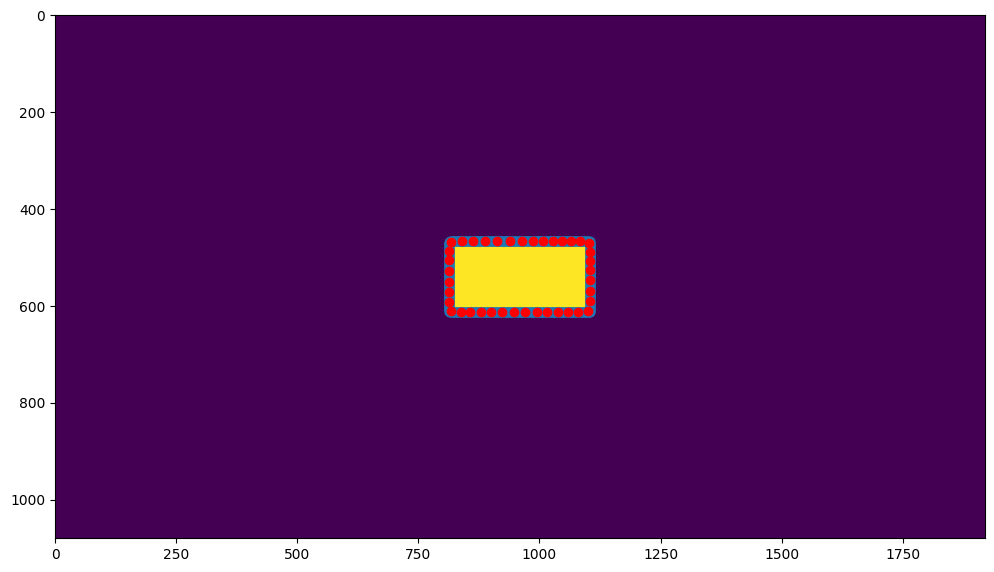

In [16]:
seg_map = cv2.imread('./data/testing/boundary.png', 0)

boundary = cv2.Canny(seg_map,100,200)
boundary_pts = np.array(np.where(boundary==255)).T

kmeans = KMeans(n_clusters=40, random_state=0).fit(boundary_pts)
cluster_centers = kmeans.cluster_centers_

plt.figure(figsize=(12,15))
plt.imshow(seg_map)
plt.scatter(boundary_pts[:,1], boundary_pts[:,0])
plt.scatter(cluster_centers[:,1], cluster_centers[:,0], c='r')

[[ 9.963e-01 -8.617e-02  0.000e+00  1.152e+02]
 [ 8.617e-02  9.963e-01  0.000e+00  5.757e+01]
 [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


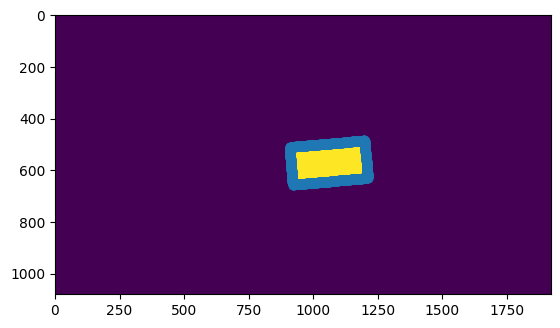

In [31]:
from utils.geometric_utils import icp


angle = 5
tx, ty = 100, 30

height, width = seg_map.shape[:2]
rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1)
translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
rotated_seg_map = cv2.warpAffine(seg_map, rotation_matrix, (width, height))
translated_seg_map = cv2.warpAffine(rotated_seg_map, translation_matrix, (width, height))
mask = translated_seg_map == 0

translated_seg_map[mask] = 0
boundary = cv2.Canny(translated_seg_map,100,200)
boundary_pts2 = np.array(np.where(boundary==255)).T
np.random.shuffle(boundary_pts2)

M = icp(boundary_pts, boundary_pts2, icp_radius=1000)
theta = np.arctan2(M[1, 0], M[0, 0])
# theta = np.linalg.norm(theta_radians)
theta_degrees = np.rad2deg(theta)
M[0,3], M[1,3],theta, theta_degrees
print(M)


plt.imshow(translated_seg_map)
plt.scatter(boundary_pts2[:,1], boundary_pts2[:,0])

[[ 9.963e-01 -8.617e-02  0.000e+00  1.152e+02]
 [ 8.617e-02  9.963e-01  0.000e+00  5.757e+01]
 [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


(115.15964195317466,
 57.573835261954514,
 0.08627447264586957,
 4.943163162325195)

In [5]:
import pickle as pkl

rewards = pkl.load(open('./data/rl_data/rl_data.pkl', 'rb'))

# Define the smoothing factor (0.9 in this example)
smoothing_factor = 0.99

# Calculate the smoothed rewards using a moving average
smoothed_rewards = [rewards[0]]
for r in rewards[1:]:
    smoothed_rewards.append(smoothed_rewards[-1] * smoothing_factor + r * (1 - smoothing_factor))

# Create a figure and plot the rewards and smoothed rewards
plt.figure(figsize=(10, 6))
plt.plot(rewards, label='Original Rewards', alpha=0.5)
plt.plot(smoothed_rewards, label='Smoothed Rewards', color='red', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Plot with 0.9 Smoothing')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './data/rl_data/rl_data.pkl'

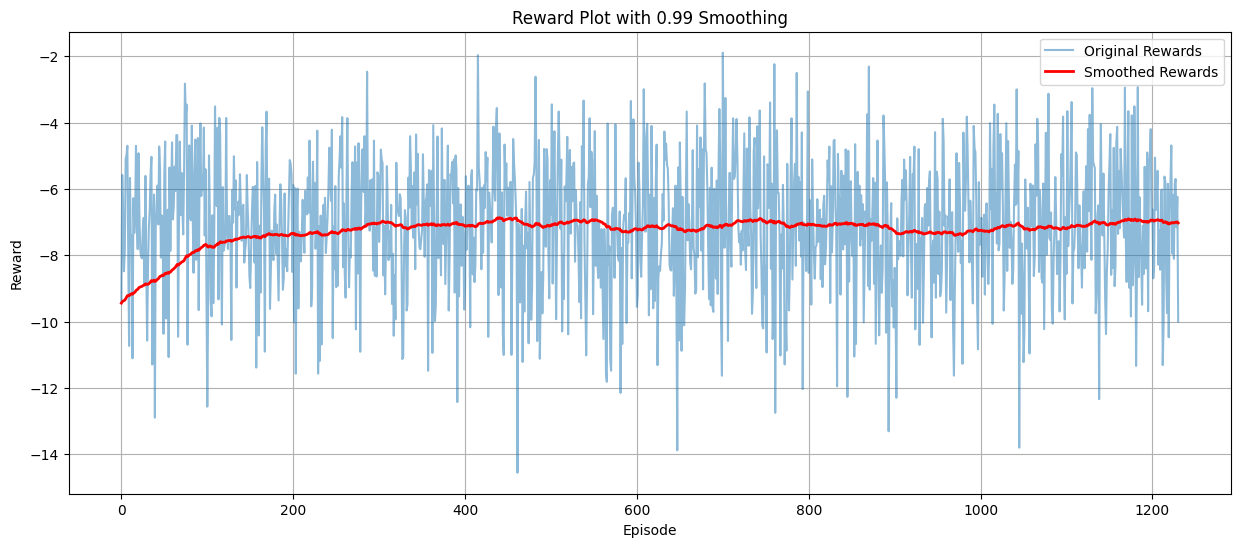

In [20]:
%matplotlib inline
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

# with open('./data/rl_data/ddpg_expt_0/ddpg_expt_0_s69420/progress.txt', 'r') as f:
# with open('./data/rl_data/backup/sac_expt_grasp/progress.txt', 'r') as f:
# with open('./data/rl_data/masac_expt_0/masac_expt_0_s69420/progress.txt', 'r') as f:
with open('./data/rl_data/matsac_expt_0/matsac_expt_0_s69420/progress.txt', 'r') as f:
    lines = f.readlines()
    rewards = [float(line.split('\t')[1]) for line in lines[1:]]

rewards = np.array(rewards)

# Define the smoothing factor (0.9 in this example)
smoothing_factor = 0.99

# Calculate the smoothed rewards using a moving average
smoothed_rewards = [rewards[0]]
for r in rewards[1:]:
    smoothed_rewards.append(smoothed_rewards[-1] * smoothing_factor + r * (1 - smoothing_factor))

# Create a figure and plot the rewards and smoothed rewards
plt.figure(figsize=(15, 6))
plt.plot(rewards, label='Original Rewards', alpha=0.5)
plt.plot(smoothed_rewards, label='Smoothed Rewards', color='red', linewidth=2)
# plt.ylim(-200, 0)
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.title(f'Reward Plot with {smoothing_factor} Smoothing')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [12]:

temp = ''.join(lines)
with open('./data/legacy/ddpg_expt_500iters_normalized.txt', 'w') as new_f:
    new_f.write(temp)

In [1]:
import numpy as np
plane_size = 1000*np.array([(0 - 0.063, 0 - 0.2095), (0.2625 + 0.063, 0.303107 + 0.1865)])
delta_plane_x = plane_size[1][0] - plane_size[0][0]
delta_plane_y = plane_size[1][1] - plane_size[0][1]
rad = 150
pix_rad =(rad - plane_size[0][0])/(plane_size[1][0]-plane_size[0][0])*1080
pix_rad

592.1235521235521

In [3]:
robot_positions = np.zeros((8,8,2))
for i in range(8):
    for j in range(8):
        if i%2!=0:
            finger_pos = np.array((i*37.5, j*43.301 - 21.65))
        else:
            finger_pos = np.array((i*37.5, j*43.301))

        finger_pos[0] = (finger_pos[0] - plane_size[0][0])/(plane_size[1][0]-plane_size[0][0])*1080 - 0
        finger_pos[1] = 1920 - (finger_pos[1] - plane_size[0][1])/(plane_size[1][1]-plane_size[0][1])*1920
        finger_pos = finger_pos.astype(np.int32)
        robot_positions[i,j] = finger_pos

robot_positions

array([[[ 175., 1344.],
        [ 175., 1225.],
        [ 175., 1106.],
        [ 175.,  987.],
        [ 175.,  868.],
        [ 175.,  750.],
        [ 175.,  631.],
        [ 175.,  512.]],

       [[ 279., 1404.],
        [ 279., 1285.],
        [ 279., 1166.],
        [ 279., 1047.],
        [ 279.,  928.],
        [ 279.,  809.],
        [ 279.,  690.],
        [ 279.,  571.]],

       [[ 383., 1344.],
        [ 383., 1225.],
        [ 383., 1106.],
        [ 383.,  987.],
        [ 383.,  868.],
        [ 383.,  750.],
        [ 383.,  631.],
        [ 383.,  512.]],

       [[ 487., 1404.],
        [ 487., 1285.],
        [ 487., 1166.],
        [ 487., 1047.],
        [ 487.,  928.],
        [ 487.,  809.],
        [ 487.,  690.],
        [ 487.,  571.]],

       [[ 592., 1344.],
        [ 592., 1225.],
        [ 592., 1106.],
        [ 592.,  987.],
        [ 592.,  868.],
        [ 592.,  750.],
        [ 592.,  631.],
        [ 592.,  512.]],

       [[ 696., 1404.],
      

In [4]:
var = np.array([50, 50])
pix1 = np.array([(var[0] - plane_size[0][0])/(plane_size[1][0]-plane_size[0][0])*1080 - 0, 1920 - (var[1] - plane_size[0][1])/(plane_size[1][1]-plane_size[0][1])*1920])
var = np.array([150, 100])
pix2 = np.array([(var[0] - plane_size[0][0])/(plane_size[1][0]-plane_size[0][0])*1080 - 0, 1920 - (var[1] - plane_size[0][1])/(plane_size[1][1]-plane_size[0][1])*1920])

var = [100, 30]
var*np.array((1080/(plane_size[1][0]-plane_size[0][0]), 1920/(plane_size[1][1]-plane_size[0][1])))

array([277.99227799,  82.39082143])

In [22]:
robot_positions[2,2], robot_positions[2, 7], robot_positions[1,3]

(array([ 383., 1106.]), array([383., 512.]), array([ 279., 1047.]))

: 

In [7]:
finger_pos

array([904, 571], dtype=int32)